# **Analysis of garmin .fit files** 📊 
The following script needs as an input a **.csv** file made by the mix of a serie of **.fit** files. In order to create the input needed, use the ***from_garmin_tool.py*** included in this repository.

The analysis is divided in two sections: 
<ol>
<li><b>Distance progression</b> and type of runs. 🏁 </li> 
<li><b>Race performance</b> based on speed, heart rate and altitude difference.🏃</li> 
</ol>

In [1]:
### Import packages
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
### Read dataset
historic = pd.read_csv('historic_data.csv')

#### **1. Data transformation - Distance progression** 🏁                                     
Some categories must be created in order to organize the analysis. Mainly date and speed transformation, also based on the running habits all the races performed on sunday are categorized as long runs.

In [3]:
### Transformation of historic records
historic['Speed min/km'] = historic['Speed'].apply(lambda x: (3600/x)/60 if x != 0 else 0)
historic['Day'] = historic['Date'].apply(lambda x: x[:10])
historic['Month'] = historic['Date'].apply(lambda x: x[:7])
historic['Dates'] = pd.to_datetime(historic.loc[:,'Timestamp'],unit='s')
historic['Day_of_the_week'] = historic['Dates'].dt.dayofweek
historic['Run_type'] = historic.loc[:,'Day_of_the_week'].apply(lambda x : 'Long_run' if x == 6 else 'Regular run')

### Aggregation of historic records
grouped_df = historic.groupby(['Day'],as_index=False).agg({'Distance':['max'],'Speed':['mean','std'],'Dates':['max'],'Run_type':['max'],'Month':['max'],'Altitude':['max','min'],'Heart_rate':['max','min','mean','std']})
grouped_df.columns = ['Day','Total_distance','Avg_speed','Std_speed','Date','Run_type','Month','Altitude_max','Altitude_min','HR_max','HR_min','HR_mean','HR_std']  
grouped_df['Total_distance'] = grouped_df['Total_distance']/1000 

### Add months without records
dec2022 = pd.DataFrame({'Day':['2022-12-15'],'Total_distance':[0],'Avg_speed':[0],'Date':['2022-12-15 07:45:27'],'Run_type':['No_run'],'Month':['2022-12']})
jan2023 = pd.DataFrame({'Day':['2023-01-15'],'Total_distance':[0],'Avg_speed':[0],'Date':['2023-01-15 07:45:27'],'Run_type':['No_run'],'Month':['2023-01']})
grouped_df = pd.concat([grouped_df,dec2022],ignore_index=True,axis=0)
grouped_df = pd.concat([grouped_df,jan2023],ignore_index=True,axis=0)

### Run type percentage creation
cross_table = pd.crosstab(index=grouped_df['Month'],columns=grouped_df['Run_type'],values=grouped_df['Total_distance'],aggfunc='sum',normalize='index')

### Sort aggregation
grouped_df = grouped_df.sort_values(by='Month')

#### **1. Data visualization - Distance progression** 🏁  
Three charts are created:
1. **Distance progression by type of run:** swarm plot where the most frequent distances can be seen.
2. **Distance progression:** non cumulative barplot showing how month by month the total distance has increased.
3. **Run type distribution:** full stacked bar plot to show the distribution of kilometers ran in regular vs long runs.

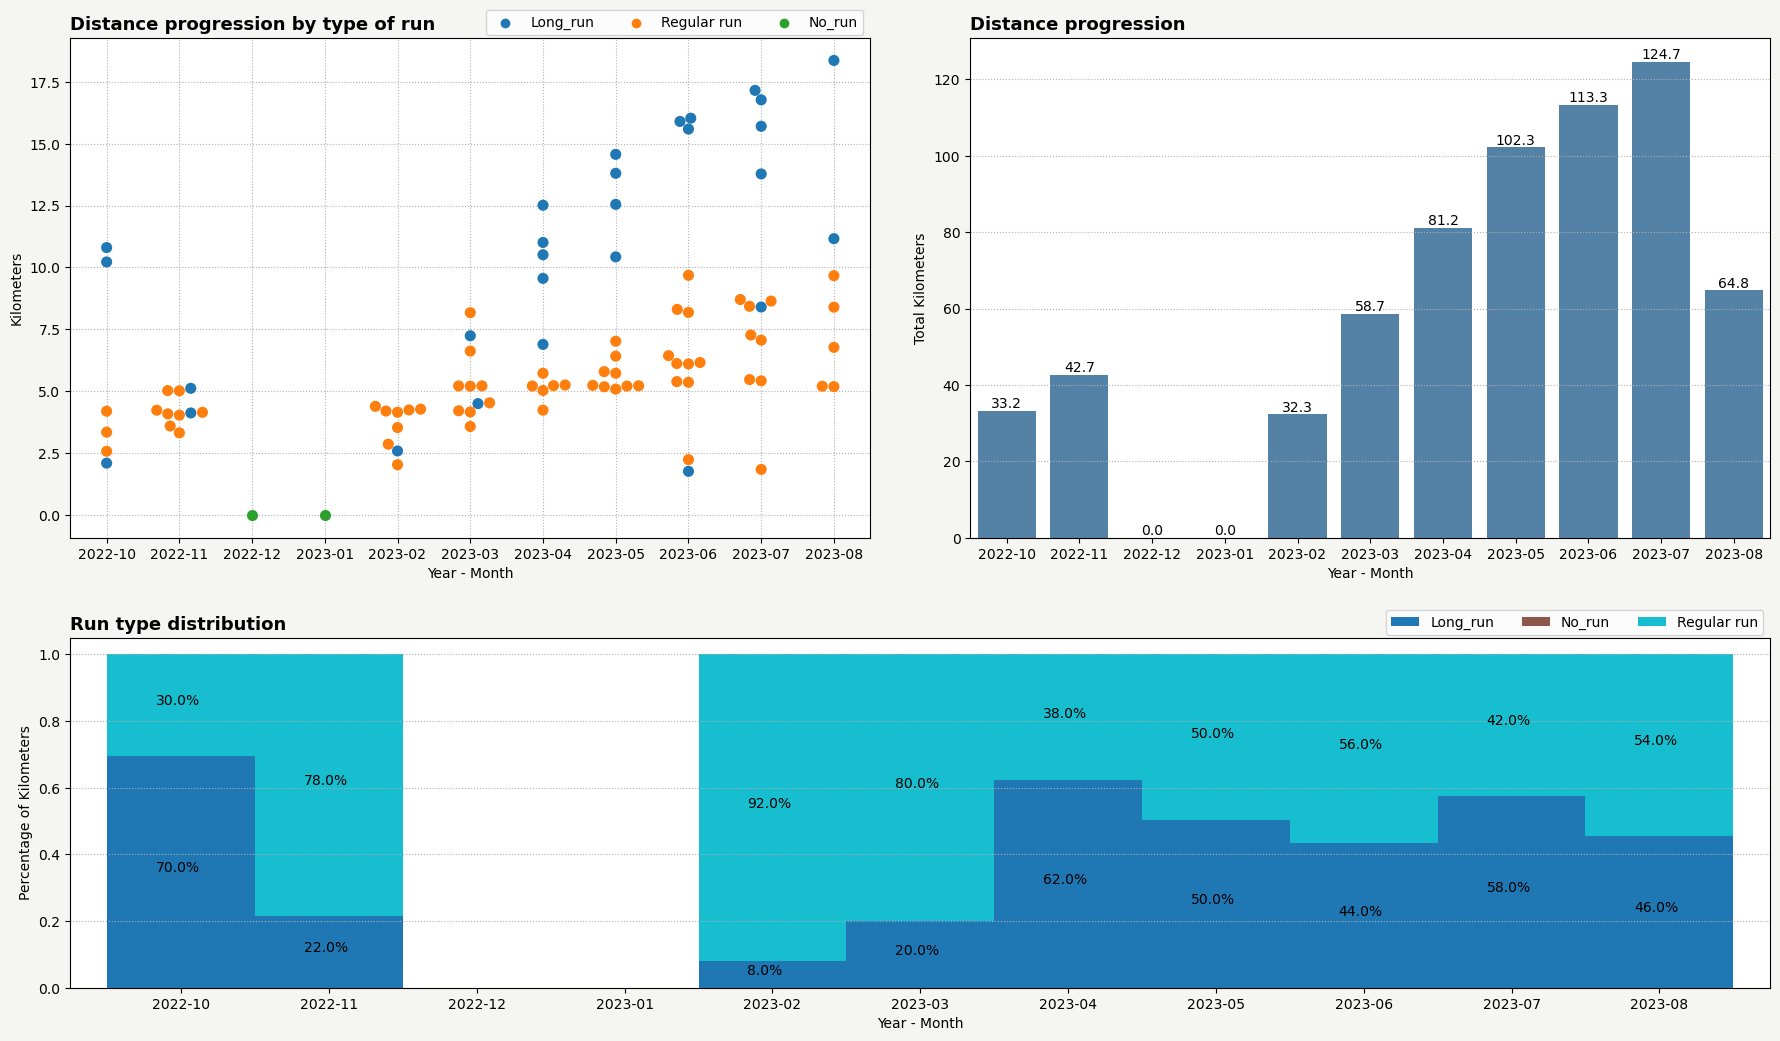

In [31]:
### Create the figure and main title
fig1 = plt.figure(figsize=(10,5), facecolor='#F5F5F1')
fig1.subplots_adjust(top=20)

### Create the axes
ax1 = fig1.add_axes((0,0,0.8,1), facecolor='white')
ax2 = fig1.add_axes((0.9,0,0.8,1), facecolor='white')
ax3 = fig1.add_axes((0,-0.9,1.7,0.7), facecolor='white')

### Create the charts for each axes
sns.swarmplot(data=grouped_df,x='Month',y='Total_distance',hue='Run_type',dodge=False,s=8,ax=ax1,palette='tab10') # ax1
sns.barplot(data=grouped_df,x='Month',y='Total_distance',estimator='sum',errorbar=None,color='steelblue',ax=ax2) # ax2
cross_table.plot(kind='bar',stacked=True,colormap='tab10',ax=ax3, width=1) # ax3

### Style the axes
# ax1
ax1.set_title('Distance progression by type of run',loc='left',size=13,fontweight='bold')
ax1.set_xlabel('Year - Month')
ax1.set_ylabel('Kilometers')
ax1.legend(loc='upper right',bbox_to_anchor=(1,1.07),ncol=3)
ax1.xaxis.grid(True,linestyle=':')
ax1.yaxis.grid(True,linestyle=':')

# ax2
ax2.set_title('Distance progression',loc='left', size=13,fontweight='bold')
ax2.set_xlabel('Year - Month')
ax2.set_ylabel('Total Kilometers')
ax2.bar_label(ax2.containers[0], fmt='%.1f')
ax2.yaxis.grid(True,linestyle=':')

# ax3
ax3.set_title('Run type distribution',loc='left', size=13,fontweight='bold')
ax3.set_xlabel('Year - Month')
ax3.set_ylabel('Percentage of Kilometers')
ax3.legend(loc='upper right',bbox_to_anchor=(1,1.1),ncol=3)
plt.setp(ax3.get_xticklabels(), rotation=0, ha="center",rotation_mode="anchor")
ax3.yaxis.grid(True,linestyle=':')

# Others
for n, x in enumerate([*cross_table.index.values]):
    for (proportion, y_loc) in zip(cross_table.loc[x],cross_table.loc[x].cumsum()):
        if proportion == 0:
            ax3.text(x=0,y=0,s='')
        else:
            ax3.text(x=n - 0.17,y=(y_loc - proportion) + (proportion / 2), s=f'{np.round(proportion * 100)}%', color="black",fontsize=10)

# Render
fig1.savefig('Distance_progression.png',facecolor='w',bbox_inches='tight')
plt.show()

#### **2. Data transformation - Race performance. 🏃**
Some filtering of the data and new categories must be created in order to organize the analysis. Based on the running habits, any speed below 7 Km/h is excluded and only months of continuos running activity are included

In [5]:
### Filter speed and date
filter_speed = historic['Speed'] > 7
filter_timestamp = historic['Timestamp'] >= 1672531201

### Dataset for race performance
historic_speed = historic[filter_speed & filter_timestamp].sort_values('Timestamp')

### Aggregation of performance records
grouped_speed = historic_speed.groupby(['Day'],as_index=False).agg({'Distance':['max'],'Speed':['mean','std'],'Dates':['max'],'Run_type':['max'],'Month':['max'],'Altitude':['max','min'],'Heart_rate':['max','min','mean','std']})
grouped_speed.columns = ['Day','Total_distance','Avg_speed','Std_speed','Date','Run_type','Month','Altitude_max','Altitude_min','HR_max','HR_min','HR_mean','HR_std']
grouped_speed['H_diff']=(grouped_speed['Altitude_max']-grouped_speed['Altitude_min'])

#### **1. Data visualization - Race performance** 🏃  
Three charts are created:
1. **Average speed by day:** line plot with trend line (regresion plot) based on the average speed for each race.
2. **Average heart rate by day:** line plot with trend line (regresion plot) based on the average heart rate for each race.
3. **Average altitude by day:** line plot based on the altitude in meters above sea level of each race and trend line (regresion plot) based on the altitude difference of each race.

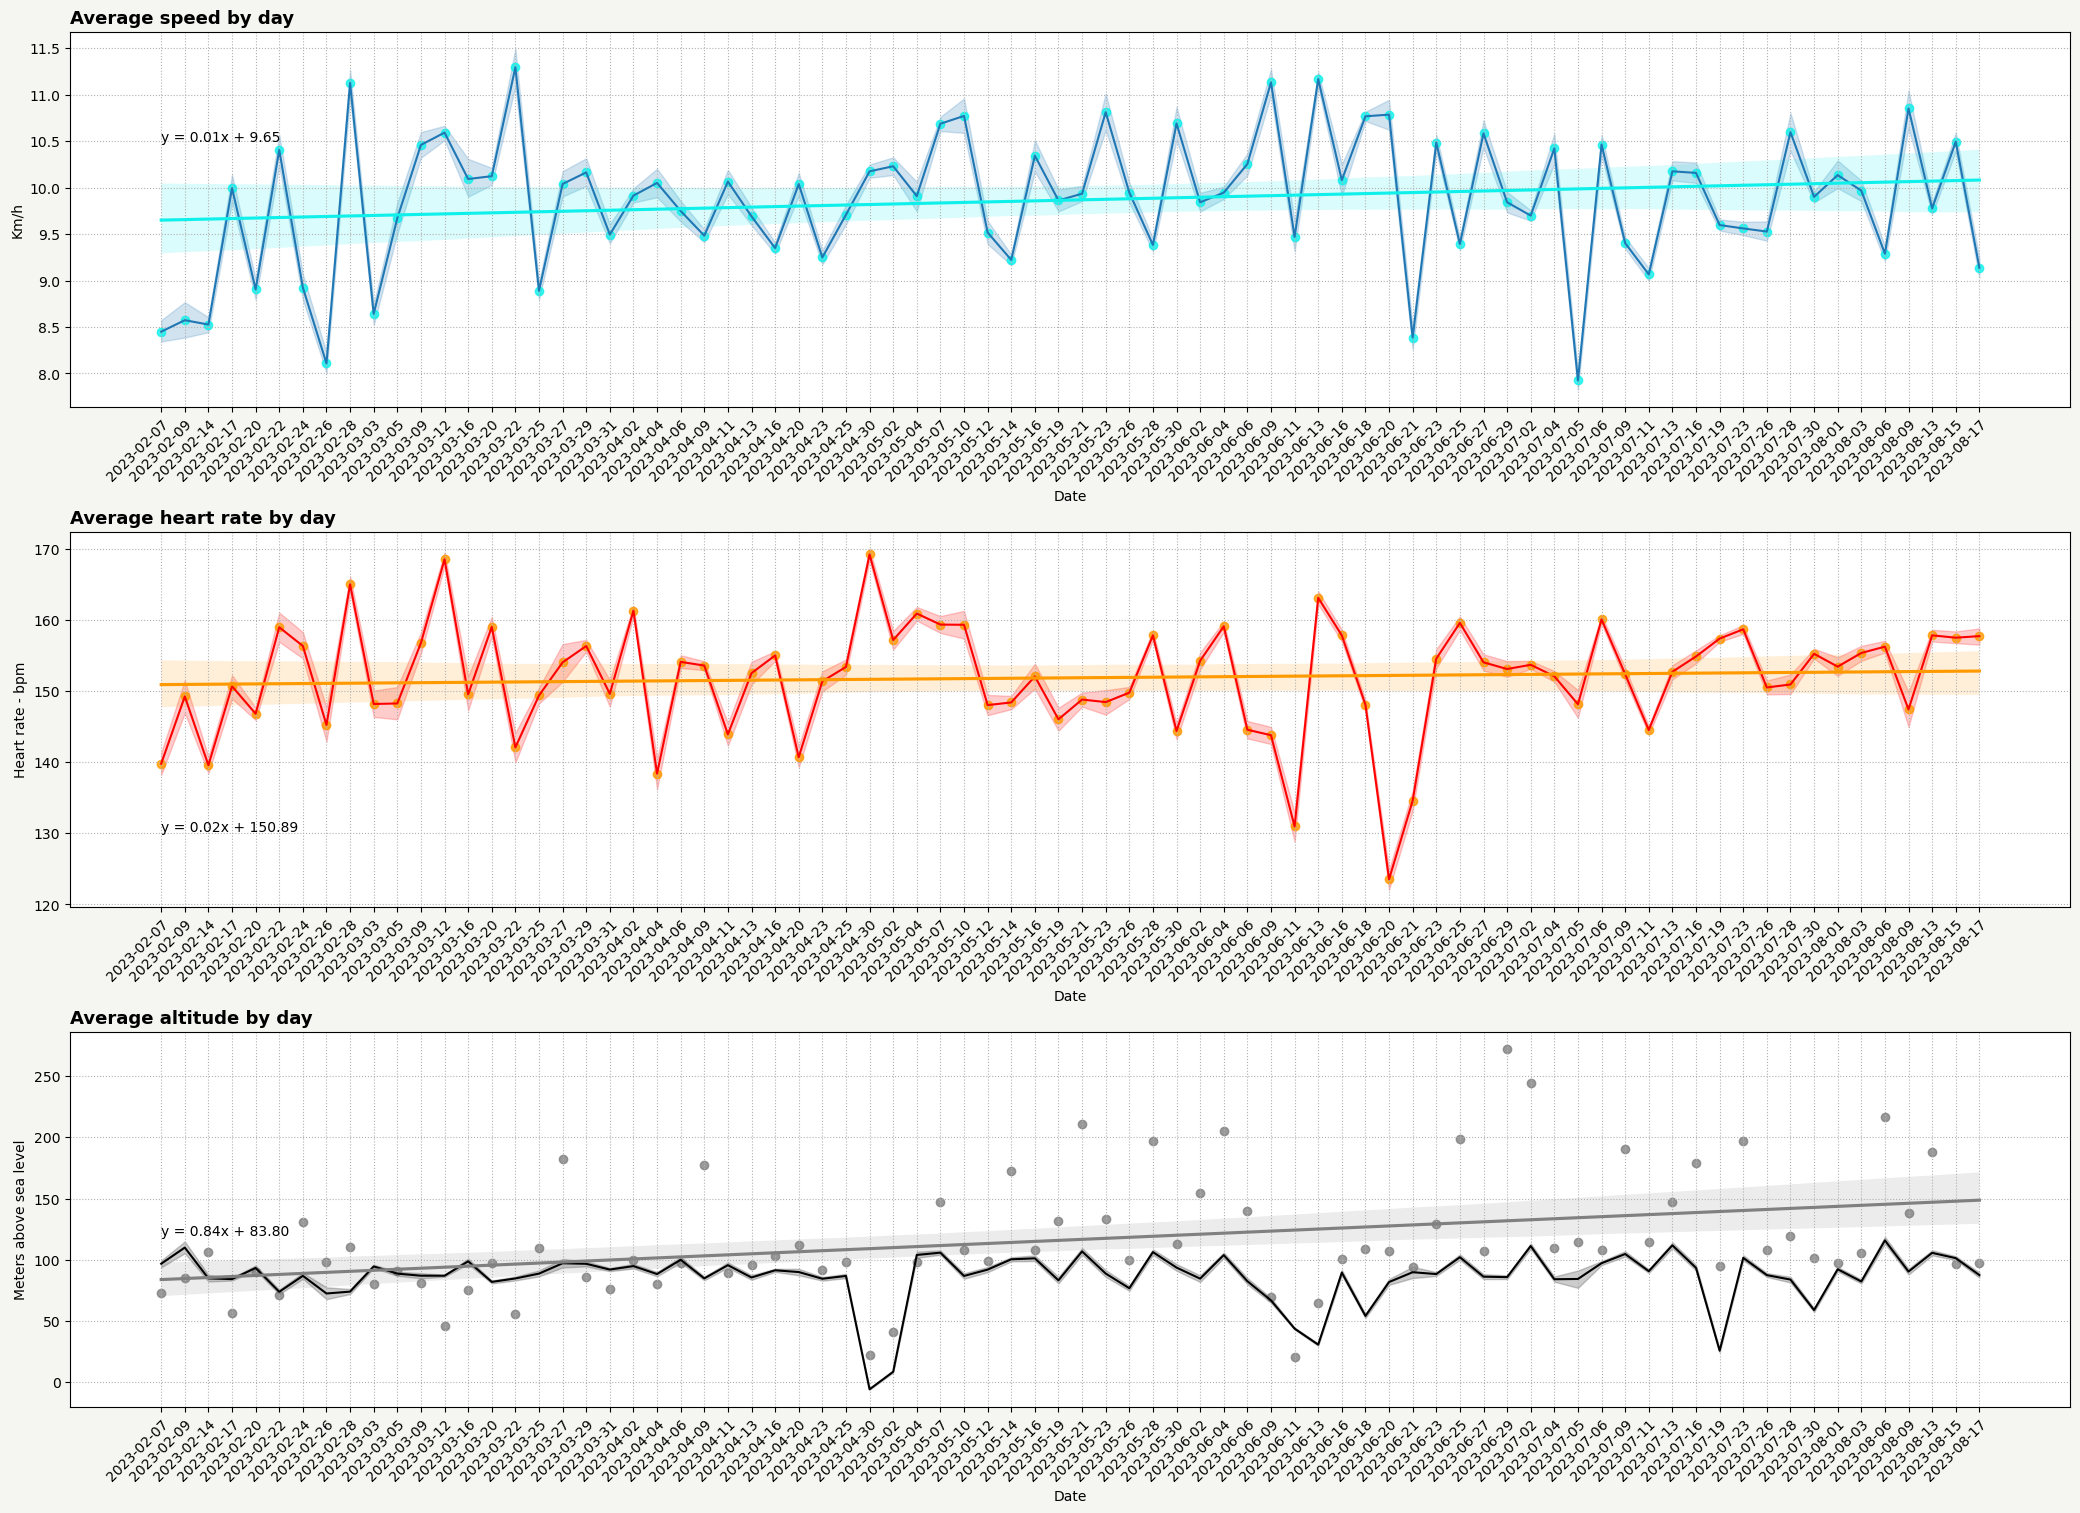

In [32]:
### Create the figure and main title
fig2 = plt.figure(figsize=(10,5), facecolor='#F5F5F1')
fig2.subplots_adjust(top=20)

### Create the axes
ax1 = fig2.add_axes((0,1,2,0.75), facecolor='white')
ax2 = fig2.add_axes((0.0,0,2,0.75), facecolor='white')
ax3 = fig2.add_axes((0,-1,2,0.75), facecolor='white')

### Create the charts for each axes
sns.lineplot(data=historic_speed,x='Day',y='Speed',ax=ax1) # ax1
sns.regplot(data=grouped_speed,x=grouped_speed.index,y='Avg_speed',color='#10F0EB',ax=ax1) # ax1
sns.lineplot(data=historic_speed,x='Day',y='Heart_rate',color='r',ax=ax2) # ax2
sns.regplot(data=grouped_speed,x=grouped_speed.index,y='HR_mean',color='#FF9900',ax=ax2) # ax2
sns.lineplot(data=historic_speed,x='Day',y='Altitude',color='black',ax=ax3) # ax3
sns.regplot(data=grouped_speed,x=grouped_speed.index,y='H_diff',color='gray',ax=ax3) # ax3


### Style the axes
# ax1
ax1.set_title('Average speed by day',loc='left',size=13,fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Km/h')
ax1.xaxis.grid(True,linestyle=':')
ax1.yaxis.grid(True,linestyle=':')
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

# ax2
ax2.set_title('Average heart rate by day',loc='left',size=13,fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Heart rate - bpm')
ax2.xaxis.grid(True,linestyle=':')
ax2.yaxis.grid(True,linestyle=':')
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

# ax3
ax3.set_title('Average altitude by day',loc='left',size=13,fontweight='bold')
ax3.set_xlabel('Date')
ax3.set_ylabel('Meters above sea level')
ax3.xaxis.grid(True,linestyle=':')
ax3.yaxis.grid(True,linestyle=':')
plt.setp(ax3.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

# Others
slope_ax1, intercept_ax1 = np.polyfit(grouped_speed.index, grouped_speed["Avg_speed"], 1)
ax1.text(0,10.5,s=f"y = {slope_ax1:.2f}x + {intercept_ax1:.2f}")

slope_ax2, intercept_ax2 = np.polyfit(grouped_speed.index, grouped_speed["HR_mean"], 1)
ax3.text(0,450,s=f"y = {slope_ax2:.2f}x + {intercept_ax2:.2f}")

slope_ax3, intercept_ax3 = np.polyfit(grouped_speed.index, grouped_speed["H_diff"], 1)
ax3.text(0,120,s=f"y = {slope_ax3:.2f}x + {intercept_ax3:.2f}")

# Render
fig2.savefig('Race_performance.jpg',facecolor='w',bbox_inches='tight')
plt.show()